In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../src'

/media/apfriend/sabrent/ucsd/classes/cse151b/kaggle/src


In [120]:
import os
import sys
import re
import shutil
import pandas as pd
import random
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import multiprocessing
from tqdm.auto import tqdm
import seaborn as sns
from IPython.display import display

#####LOCAL SCRIPTS FROM src#####
import utility
import load_data as load_data
import models.lstm as lstm
import models.linear as linear
import models.physics as physics
from ArgoverseDataset import ArgoverseDataset
import run_model as run_model



In [116]:
device='cuda:0'
test_path='../data/test-data'
val_path='../data/validation-data/new_val_in'
train_path='../data/train-data'
model_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/trained-models/final-models'

In [125]:
help('a'.replace)

Help on built-in function replace:

replace(old, new, count=-1, /) method of builtins.str instance
    Return a copy with all occurrences of substring old replaced by new.
    
      count
        Maximum number of occurrences to replace.
        -1 (the default value) means replace all occurrences.
    
    If the optional argument count is given, only the first count occurrences are
    replaced.



RMSE: 27.795698


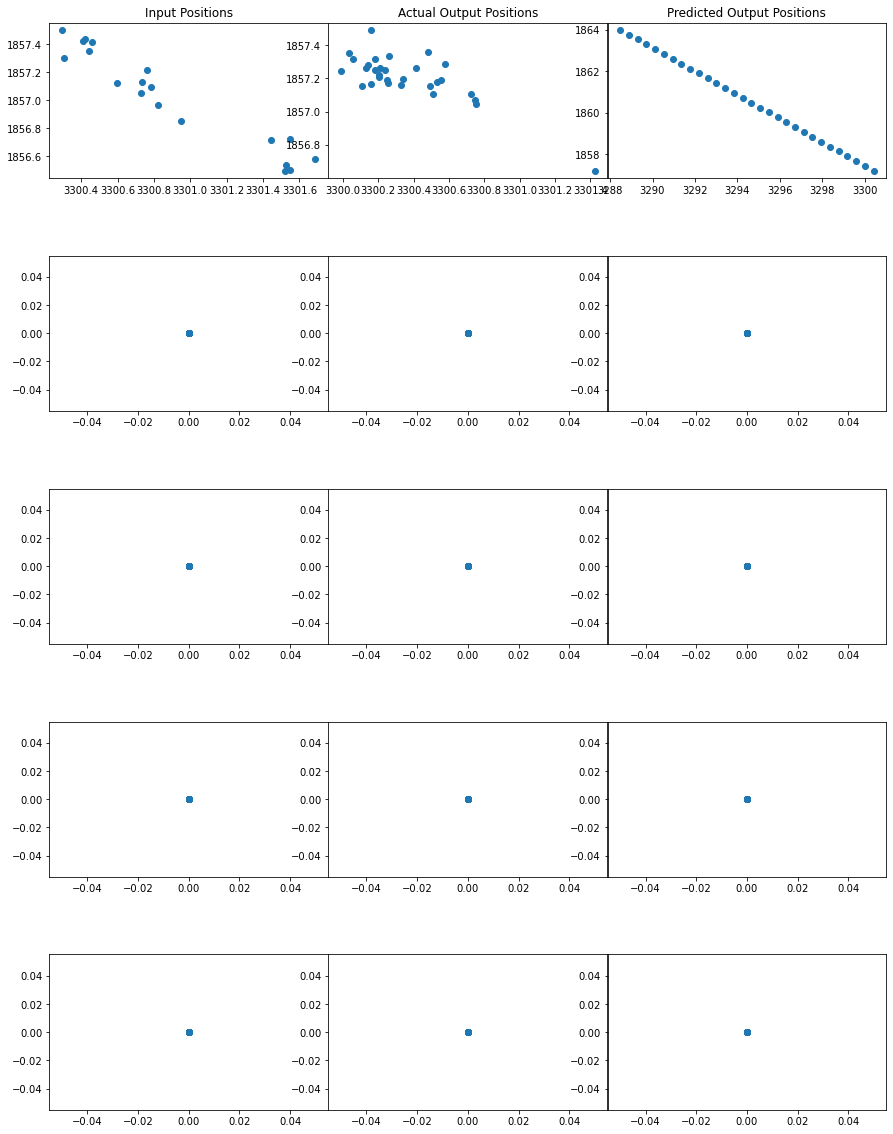

In [135]:
test_inp, test_out=load_data.get_test_data(test_path, 3000)
test_inp, test_out=test_inp.to(device), test_out.to(device)
test_pred=physics.avg_velocity_model(test_inp)

pos_idx=torch.tensor([0,1]).to(device)
test_out_pos=torch.index_select(test_out, 3, pos_idx)
print('RMSE: %f'%utility.rmse(test_pred, test_out_pos).detach().cpu().numpy())

# utility.visualize_trajectory(test_inp, test_out_pos, test_pred)

In [275]:
models=os.listdir(model_path)
replace_str=r'0\.\d{2}0000'
new_str=r''

for model in models:
    model_name=model.split('.')[0]
    if model_name in model_names.keys():
        model_name_new=model_names[model_name]#+'.pth'
        model_name_new=model_name_new.replace('0.','').replace('0000','')
        model_name_new+='.pth'
        
        src_fn=os.path.join(model_path, model)
        dst_fn=os.path.join(model_path, model_name_new)
        os.rename(src_fn,dst_fn)

In [189]:
os.listdir(model_path)

['final-multilayer-linear-dropout25-batchsz128-epoch1.pth',
 'final-multilayer-linear-dropout25-batchsz128-epoch5.pth',
 'final-multilayer-linear-dropout25-batchsz16-epoch1.pth',
 'final-multilayer-linear-dropout25-batchsz16-epoch5.pth',
 'final-multilayer-linear-dropout25-batchsz32-epoch1.pth',
 'final-multilayer-linear-dropout25-batchsz32-epoch5.pth',
 'final-multilayer-linear-dropout25-batchsz64-epoch1.pth',
 'final-multilayer-linear-dropout25-batchsz64-epoch5.pth',
 'final-multilayer-linear-dropout50-batchsz128-epoch1.pth',
 'final-multilayer-linear-dropout50-batchsz128-epoch10.pth',
 'final-multilayer-linear-dropout50-batchsz128-epoch5.pth',
 'final-multilayer-linear-dropout50-batchsz16-epoch1.pth',
 'final-multilayer-linear-dropout50-batchsz16-epoch5.pth',
 'final-multilayer-linear-dropout50-batchsz32-epoch1.pth',
 'final-multilayer-linear-dropout50-batchsz32-epoch5.pth',
 'final-multilayer-linear-dropout50-batchsz64-epoch1.pth',
 'final-multilayer-linear-dropout50-batchsz64-epoc

In [276]:
model_df=utility.compare_rmse(
    src=model_path,
    data_path=test_path
)
model_df

100%|██████████| 83/83 [01:03<00:00,  1.30it/s]


,model_name,rmse,dropout,batch_size,num_epochs
0,Average Velocity Model,28.213305,NaN,128,NaN
1,multilayer linear,108.430809,0.25,128,1.0
2,multilayer linear,39.542477,0.25,128,10.0
3,multilayer linear,44.026596,0.25,128,5.0
4,multilayer linear,148.802948,0.25,16,1.0
...,...,...,...,...,...
78,simple linear,260.999298,0.75,16,5.0
79,simple linear,543.919556,0.75,32,1.0
80,simple linear,222.108597,0.75,32,5.0
81,simple linear,540.612000,0.75,64,1.0


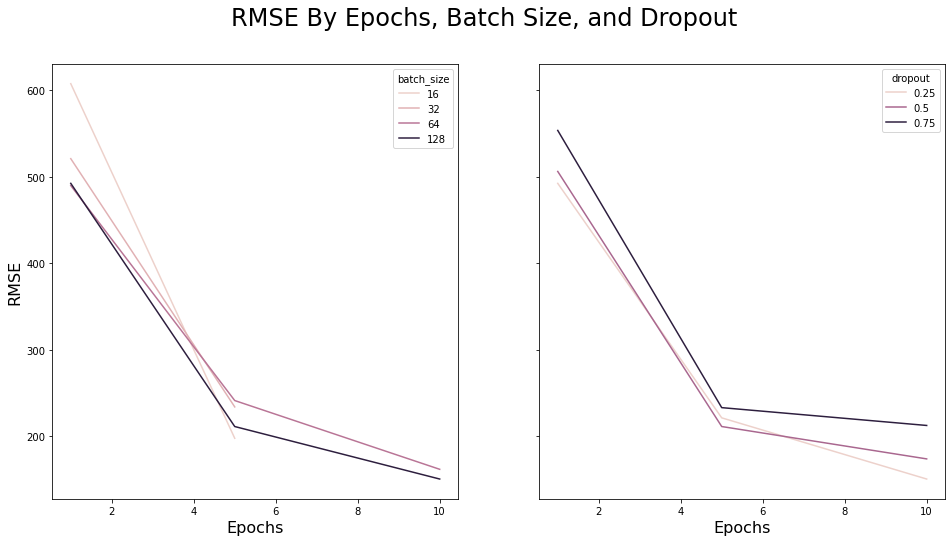

In [277]:
utility.visualize_model_loss(model_df, 'simple linear', 'epoch')
# model_df.dtypes

In [223]:

min_rmse=model_df.groupby(by='model_name').rmse.min()
# model_df.loc[model_df.rmse.isin(min_rmse)]
idxs=[]
for min_loss in min_rmse:
    idx=model_df.loc[model_df.rmse==min_loss].index.values[0]
    idxs.append(idx)
model_df.iloc[idxs,:]

,model_name,rmse,dropout,batch_size,num_epochs
0,Average Velocity Model,27.092701,NaN,128,NaN
2,multilayer linear,42.824436,0.25,128,5.0
38,multilayer linear2,474.45038,0.50,16,5.0
55,simple linear,149.15347,0.25,128,10.0


In [213]:
min_rmse

[27.092700958251953, 42.82443618774414, 474.45037841796875, 149.15347290039062]

In [171]:
test_fn='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/trained-models/final-models/final-multilayer-linear-dropout25-batchsz128-epoch1.pth'

type(torch.load(test_fn))

collections.OrderedDict

In [104]:
submit_dir='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/submit-data'
physics_submit_fn='physics-model-submit.csv'

submit_df=run_model.submit_model(
    model=physics.avg_velocity_model,
    data_path=val_path,
    batch_size=128,
    save_path=submit_dir,
    save_fn=physics_submit_fn,
    physics_model=True
)

submit_df

100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1722.862793,344.908600,1731.862915,353.518494,1740.863037,362.128357,1749.863159,370.738220,1758.863403,...,1947.866211,560.155396,1956.866333,568.765320,1965.866455,577.375183,1974.866699,585.985046,1983.866699,594.594910
1,10015,724.523743,1226.880127,723.511047,1223.799072,722.498291,1220.718018,721.485535,1217.636963,720.472778,...,699.205261,1149.854004,698.192505,1146.772949,697.179810,1143.691895,696.167053,1140.610840,695.154297,1137.529785
2,10019,575.700317,1244.186401,577.596252,1243.683350,579.492249,1243.180176,581.388245,1242.677124,583.284180,...,623.099731,1231.609375,624.995667,1231.106323,626.891663,1230.603271,628.787598,1230.100098,630.683594,1229.597046
3,10028,1696.872559,320.736633,1702.991699,326.379883,1709.110718,332.023102,1715.229736,337.666321,1721.348877,...,1849.849121,461.817322,1855.968140,467.460571,1862.087280,473.103821,1868.206299,478.747009,1874.325317,484.390259
4,1003,2111.357910,667.496155,2098.635742,656.805664,2085.913818,646.115234,2073.191895,635.424744,2060.469727,...,1793.307739,400.234283,1780.585815,389.543823,1767.863770,378.853333,1755.141846,368.162842,1742.419800,357.472382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,258.019531,804.328186,259.845276,803.041077,261.671021,801.753967,263.496765,800.466858,265.322510,...,303.663147,772.150391,305.488892,770.863281,307.314636,769.576172,309.140350,768.289062,310.966095,767.001953
3196,99,588.072449,1148.757568,588.309082,1143.011353,588.545776,1137.265259,588.782410,1131.519165,589.019104,...,593.989075,1005.104370,594.225708,999.358215,594.462402,993.612122,594.699036,987.865967,594.935730,982.119873
3197,9905,1754.132568,447.194000,1752.528442,450.522766,1750.924438,453.851501,1749.320312,457.180267,1747.716309,...,1714.030884,530.412720,1712.426880,533.741455,1710.822754,537.070251,1709.218750,540.398987,1707.614624,543.727722
3198,9910,574.143311,1287.442139,573.582275,1285.806885,573.021179,1284.171631,572.460083,1282.536255,571.898987,...,560.116333,1246.560303,559.555237,1244.925049,558.994202,1243.289795,558.433105,1241.654541,557.872009,1240.019287


In [34]:
models=[linear.simple_model, linear.multilayer_model, linear.multilayer_model2]
model_names=['simple-linear','multilayer-linear','multilayer-linear2']

model_dict=dict(zip(models, model_names))

batch_szs=[128,64,32,16]
epochs=[1,5,10,20,30]
dropout_list=[0.5,0.75,0.25]

model_names={}

idx=1

for epoch in epochs:
    for batch_sz in batch_szs:
        for dropout in dropout_list:
            for model in models:
                name='final-'+model_dict[model]+'-dropout%f-batchsz%i-epoch%i'%(dropout,batch_sz,epoch)
                old_name='model-test-%i'%idx
                model_names[old_name]=name
                idx+=1
model_names
                

{'model-test-1': 'final-simple-linear-dropout0.500000-batchsz128-epoch1',
 'model-test-2': 'final-multilayer-linear-dropout0.500000-batchsz128-epoch1',
 'model-test-3': 'final-multilayer-linear2-dropout0.500000-batchsz128-epoch1',
 'model-test-4': 'final-simple-linear-dropout0.750000-batchsz128-epoch1',
 'model-test-5': 'final-multilayer-linear-dropout0.750000-batchsz128-epoch1',
 'model-test-6': 'final-multilayer-linear2-dropout0.750000-batchsz128-epoch1',
 'model-test-7': 'final-simple-linear-dropout0.250000-batchsz128-epoch1',
 'model-test-8': 'final-multilayer-linear-dropout0.250000-batchsz128-epoch1',
 'model-test-9': 'final-multilayer-linear2-dropout0.250000-batchsz128-epoch1',
 'model-test-10': 'final-simple-linear-dropout0.500000-batchsz64-epoch1',
 'model-test-11': 'final-multilayer-linear-dropout0.500000-batchsz64-epoch1',
 'model-test-12': 'final-multilayer-linear2-dropout0.500000-batchsz64-epoch1',
 'model-test-13': 'final-simple-linear-dropout0.750000-batchsz64-epoch1',
 '